## EARTH OBSERVATION DATA ANALYSIS
### EXERCISE 5
- NAME : VIKRANTH ALE 
- MATRICOLA : 1873995

In [1]:
#loading required libraries
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt

In [2]:
#Loading the input channel data
ch1 = np.loadtxt('Image_ch1_spectralRadiance.dat')
ch2 = np.loadtxt('Image_ch2_spectralReflectance.dat')
class_label = np.loadtxt('Image_class_insituLabels.dat')
surface_temp = np.loadtxt('Image_parameter_insituMeasurements.dat')

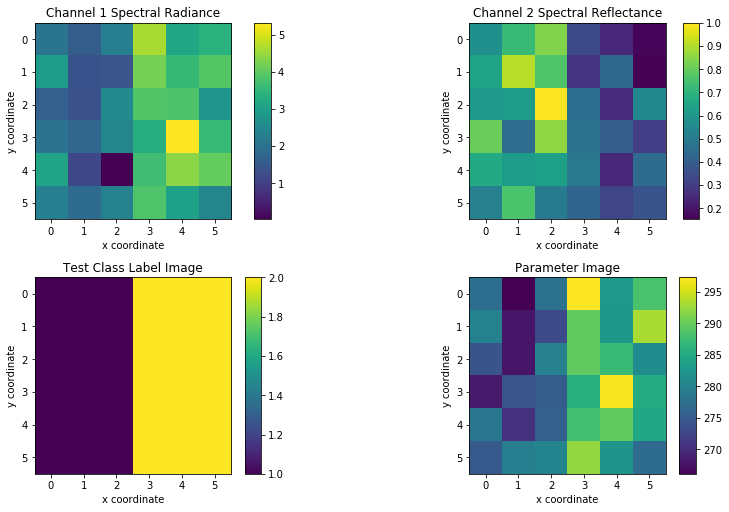

In [3]:
#plotting the matrix

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7),constrained_layout=True)
channels = [ch1,ch2,class_label,surface_temp]
titles  = ['Channel 1 Spectral Radiance','Channel 2 Spectral Reflectance','Test Class Label Image','Parameter Image']

for ax,ch,title in zip(axs.flat,channels,titles):
    clrbar = ax.imshow(ch, cmap = 'viridis', interpolation='nearest')
    fig.colorbar(clrbar, ax=ax)
    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_title(str(title))

In [4]:
# Creating a dataframe from both the channels with their labels
df = pd.DataFrame({'radiance':ch1.flatten(),'reflectance':ch2.flatten(),'label':class_label.flatten(),'surface_temp':surface_temp.flatten()})
df['label'] = df['label'].astype(int)
dff = df.copy()
dff['label'].replace(1,'cloud cover',inplace=True)
dff['label'].replace(2,'sea water',inplace=True)
dff.head(10)

,radiance,reflectance,label,surface_temp
0,2.068526,0.579204,cloud cover,277.39425
1,1.588779,0.725697,cloud cover,266.11364
2,2.308740,0.838262,cloud cover,277.84215
3,4.651697,0.338762,sea water,297.25935
4,3.197330,0.246227,sea water,282.75330
5,3.413580,0.164858,sea water,288.30717
6,2.951153,0.645951,cloud cover,279.79463
7,1.358214,0.909161,cloud cover,267.95825
8,1.429915,0.768129,cloud cover,273.07966
9,4.225014,0.284818,sea water,289.70766


In [5]:
df.columns

Index(['radiance', 'reflectance', 'label', 'surface_temp'], dtype='object')

### 1.  Plot the acquired spectral reflectance vs and spectral radiance and possibly superimpose the class label to each observation, explaining why you expect these classes can represent particle cloud and sea surface radiative signature. 

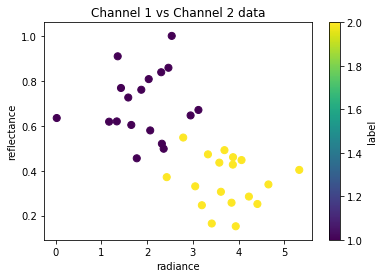

In [6]:
fig, ax = plt.subplots()

df.plot.scatter(x='radiance',y='reflectance',c='label', s=50, marker='o', \
                cmap='viridis',title='Channel 1 vs Channel 2 data',ax=ax)

We know that
For clouds,  reflectance is more and radiance is less
For seawater, reflectance is less and radiance is more

The same can be observed after analysing both channels and their surface temperature, Sea water has generally more surface temperature due to absorption of solar radiation and warms up. So it is justified that they are classified correctly due to their radiative signature.

### 2. Perform a Lloyd’s k-means unsupervised classification and, by using the in-situ class labels, compute the confusion (or contingency) matrix (CM). 

### UNSUPERVISED CLASSIFICATION
#### Lloyd's KMeans

In [7]:
Kdata =  df.copy()
Kdata = Kdata[['radiance','reflectance','surface_temp']]
Kdata.head()

,radiance,reflectance,surface_temp
0,2.068526,0.579204,277.39425
1,1.588779,0.725697,266.11364
2,2.308740,0.838262,277.84215
3,4.651697,0.338762,297.25935
4,3.197330,0.246227,282.75330


In [8]:
# KMeans
kmob = KMeans(n_clusters=2)
kmob

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
kmob.fit_predict(Kdata[['radiance','reflectance','surface_temp']])
kpred = kmob.labels_ + 1 
Kdata['cluster'] = kpred.copy()
Kdata.head(10)

,radiance,reflectance,surface_temp,cluster
0,2.068526,0.579204,277.39425,1
1,1.588779,0.725697,266.11364,1
2,2.308740,0.838262,277.84215,1
3,4.651697,0.338762,297.25935,2
4,3.197330,0.246227,282.75330,2
5,3.413580,0.164858,288.30717,2
6,2.951153,0.645951,279.79463,1
7,1.358214,0.909161,267.95825,1
8,1.429915,0.768129,273.07966,1
9,4.225014,0.284818,289.70766,2


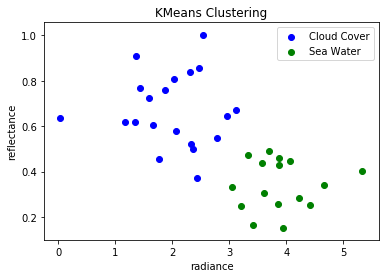

In [10]:
df1 = Kdata[Kdata.cluster==1]
df2 = Kdata[Kdata.cluster==2]

plt.scatter(df1['radiance'],df1['reflectance'],color='blue',label='Cloud Cover')
plt.scatter(df2['radiance'],df2['reflectance'],color='green',label='Sea Water')


plt.xlabel('radiance')
plt.ylabel('reflectance')
plt.title('KMeans Clustering')
plt.legend()

In [11]:
#Confusion Matrix
ConfusionM =  confusion_matrix(df['label'],kpred)
ConfusionM

array([[18,  0],
       [ 2, 16]], dtype=int64)

From the above confusion matrix , we have TP = 18, FP = 0 , FN = 2 , TN = 16

In [12]:
Accuracy_score = accuracy_score(df['label'],kpred)
Accuracy_score

0.9444444444444444

In [13]:
class_report = classification_report(df['label'],kpred)
print(class_report)

              precision    recall  f1-score   support

           1       0.90      1.00      0.95        18
           2       1.00      0.89      0.94        18

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



### 3. From the confusion matrix, compute the probability of detection (POD, sensitivity or true positive), false alarm rate (FAR, false negative) and Cohen’s index k.

                       
$Sensitivity/TPR  = \frac{TP}{TP + FN}$

$DetectionRate = \frac{TP}{TP + FP + FN + TN}$

$FalseNegative     = \frac{FN}{FN + TP}$

$FalseDicoveryRate = \frac{FP}{FP + TP}$
                         

In [14]:
# sensitivity 

sensitivity =  ConfusionM[0,0] / (ConfusionM[0,0] + ConfusionM[1,0])
print('Sensitivity is {}'.format(sensitivity))

Sensitivity is 0.9


In [15]:
#Detection Rate 

Drate = ConfusionM[0,0] / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
print('Detection Rate is {}'.format(Drate))

Detection Rate is 0.5


In [16]:
# False Negative Rate 

FNrate =  ConfusionM[1,0] / (ConfusionM[1,0] + ConfusionM[0,0])
print('False Negative Rate is {}'.format(FNrate))

False Negative Rate is 0.1


In [17]:
# False Negative Rate 

FDrate =  ConfusionM[0,1] / (ConfusionM[0,1] + ConfusionM[0,0])
print('False Discovery Rate is {}'.format(FDrate))

False Discovery Rate is 0.0


### Cohen's kappa coefficient (κ)

Manual calculation of Cohen's kappa coefficient score

$pYES = \frac{TP + FP}{TP + FP + FN + TN} * \frac{TP+FN}{TP + FP + FN + TN}$


$pNO = \frac{FN + TN}{TP + FP + FN + TN} * \frac{FP + TN}{TP + FP + FN + TN}$


$p_o = \frac{TP + TN }{ TP + FP + FN + TN}$


$p_e = pYES + pNO$
       

Therefore, Cohen's kappa coefficient (κ) is given by  $k = \frac{p_o - p_e}{1 - p_e}$

In [18]:
# calculation of po

po = (ConfusionM[0,0] + ConfusionM[1,1]) / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
print('The value of po is {}'.format(po))

The value of po is 0.9444444444444444


In [19]:
# calculation of pYES

a = (ConfusionM[0,0] + ConfusionM[0,1]) / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
b = (ConfusionM[0,0] + ConfusionM[1,0]) / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
pYES = a * b   
print('The value of pYES is {}'.format(pYES))

The value of pYES is 0.2777777777777778


In [20]:
# calculation of pNO

c = (ConfusionM[1,0] + ConfusionM[1,1]) / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
d = (ConfusionM[0,1] + ConfusionM[1,1]) / (ConfusionM[0,0] + ConfusionM[0,1] + ConfusionM[1,0] + ConfusionM[1,1])
pNO = c * d   
print('The value of pNO is {}'.format(pNO))

The value of pNO is 0.2222222222222222


In [21]:
# calculation of pe
pe = pYES + pNO
print('The value of pe is {}'.format(pe))


The value of pe is 0.5


In [22]:
# Cohen's kappa coefficient (κ)

k = (po - pe) / (1 - pe)
print('The calculated value of Cohens kappa coefficient (κ) is {}'.format(k))

The calculated value of Cohens kappa coefficient (κ) is 0.8888888888888888


In [23]:
# Calculation of cohen kappa coefficient using sklearn library

cohen_kappa_score = cohen_kappa_score(df['label'],kpred)
print('The calculated value of Cohens kappa coefficient (κ) is {}'.format(cohen_kappa_score))

The calculated value of Cohens kappa coefficient (κ) is 0.8888888888888888


From the above results, we can observe that cohen kappa coefficient calculated using sklearn library and manual method is same. Hence verified.

### 4. Determine how much variance is explained by the first principal component of the acquired channels ? 

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
pca_data = df.copy()
pca_data = pca_data[['radiance','reflectance']]
pca_data.head()

,radiance,reflectance
0,2.068526,0.579204
1,1.588779,0.725697
2,2.308740,0.838262
3,4.651697,0.338762
4,3.197330,0.246227


In [26]:
#Standardising the data
pca_data = StandardScaler().fit_transform(pca_data)
pca_data

array([[-0.6620927 ,  0.25406366],
       [-1.08193513,  0.94080534],
       [-0.45187373,  1.46849861],
       [ 1.59852333, -0.87310216],
       [ 0.32576003, -1.30689912],
       [ 0.51500768, -1.68834982],
       [ 0.11032211,  0.56696592],
       [-1.28371012,  1.80086699],
       [-1.22096182,  1.13972164],
       [ 1.22511963, -1.12598721],
       [ 0.65966952, -0.41820831],
       [ 0.9735776 , -1.7460378 ],
       [-1.02381084,  0.36825786],
       [-1.3009491 ,  0.44236225],
       [-0.25051031,  2.22671084],
       [ 0.92219254, -0.30421696],
       [ 0.89323003, -1.25407164],
       [-0.03091595,  0.10540129],
       [-0.69060837,  1.3249857 ],
       [-0.91919287, -0.32766699],
       [-0.3134984 ,  1.56153648],
       [ 0.44201   , -0.24520385],
       [ 2.18813033, -0.56974118],
       [ 0.69019642, -1.02619193],
       [ 0.25994254,  0.68116096],
       [-1.44832026,  0.43624529],
       [-2.44964027,  0.51289919],
       [ 0.7578004 , -0.15747512],
       [ 1.38762446,

In [27]:
# Principal component analysis
channel_pca = PCA(n_components=2)
channel_pca

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [28]:
# fitting and transform the data using PCA 

pca_components = channel_pca.fit_transform(pca_data)
pca_df = pd.DataFrame(pca_components,columns=['PCA 1','PCA 2'])
pca_df['label'] = df['label'].copy()
pca_df['label'].replace(1,'cloud cover',inplace=True)
pca_df['label'].replace(2,'sea water',inplace=True)
pca_df.head(10)

,PCA 1,PCA 2,label
0,0.647820,-0.288520,cloud cover
1,1.430294,-0.099794,cloud cover
2,1.357908,0.718862,cloud cover
3,-1.747703,0.512950,sea water
4,-1.154464,-0.693770,sea water
5,-1.558009,-0.829678,sea water
6,0.322896,0.478915,cloud cover
7,2.181125,0.365685,cloud cover
8,1.669255,-0.057445,cloud cover
9,-1.662484,0.070097,sea water


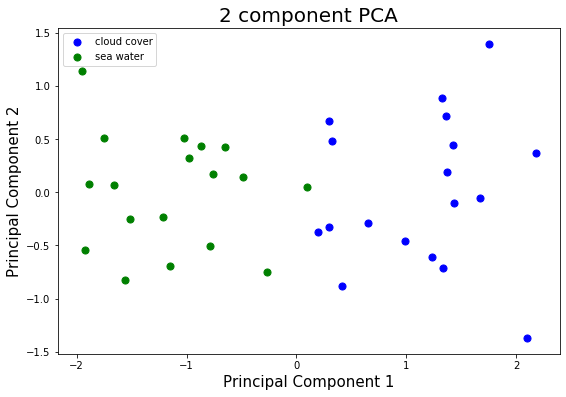

In [29]:
# Visualization of results after PCA 

fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['cloud cover', 'sea water']
colors = ['b', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = pca_df['label'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'PCA 1']
               , pca_df.loc[indicesToKeep, 'PCA 2']
               , c = color
               , s = 50)
ax.legend(targets)
#ax.grid()

In the above figure you can observe that the both classes are separated from eachother.

In [30]:
# Explained Variance Ratio of PCA 

print('Explained variance of PCA is given as {}'.format(channel_pca.explained_variance_ratio_))

Explained variance of PCA is given as [0.81709233 0.18290767]


From the above result, we can say that the First principal component of acquired channels comprises about 81.7 % variance and the second principal component comprises about 18.2 % variance.

Together both components attribute to 99.9 % of information.

### 5. By using the first principal component, re-perform a Lloyd’s k-means unsupervised classification and then compute the confusion matrix (CM) and Cohen’s index

In [31]:
Kdata2 =  df.copy()
Kdata2 = Kdata[['radiance','reflectance','surface_temp']]
Kdata2['PCA1'] = pca_df['PCA 1'].copy()
Kdata2.head()

,radiance,reflectance,surface_temp,PCA1
0,2.068526,0.579204,277.39425,0.647820
1,1.588779,0.725697,266.11364,1.430294
2,2.308740,0.838262,277.84215,1.357908
3,4.651697,0.338762,297.25935,-1.747703
4,3.197330,0.246227,282.75330,-1.154464


In [32]:
kmob2 = KMeans(n_clusters=2)
kmob2

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [33]:
kmob2.fit_predict(Kdata2[['radiance','reflectance','surface_temp','PCA1']])
kpred2 = kmob.labels_ + 1 
Kdata2['cluster'] = kpred2.copy()
Kdata2.head(10)

,radiance,reflectance,surface_temp,PCA1,cluster
0,2.068526,0.579204,277.39425,0.647820,1
1,1.588779,0.725697,266.11364,1.430294,1
2,2.308740,0.838262,277.84215,1.357908,1
3,4.651697,0.338762,297.25935,-1.747703,2
4,3.197330,0.246227,282.75330,-1.154464,2
5,3.413580,0.164858,288.30717,-1.558009,2
6,2.951153,0.645951,279.79463,0.322896,1
7,1.358214,0.909161,267.95825,2.181125,1
8,1.429915,0.768129,273.07966,1.669255,1
9,4.225014,0.284818,289.70766,-1.662484,2


In [34]:
#Confusion Matrix
ConfusionM2 =  confusion_matrix(df['label'],kpred2)
ConfusionM2

array([[18,  0],
       [ 2, 16]], dtype=int64)

In [35]:
# Calculation of cohen kappa coefficient using sklearn library

from sklearn.metrics import confusion_matrix,cohen_kappa_score

cohen_kappa_score = cohen_kappa_score(df['label'].values,kpred2)
print('The calculated value of Cohens kappa coefficient (κ) is {}'.format(cohen_kappa_score))

The calculated value of Cohens kappa coefficient (κ) is 0.8888888888888888


### 6. Apply a (running) average 3x3 numerical filter to both channel-1 and channel-2 images using a zero-padding technique and then display smoothed images comparing them with the original ones

In [36]:
import cv2

In [37]:
# Zero padding
def padding(vector,pad_width,iaxis,kwargs):
    pad_val = kwargs.get('padder',0)
    vector[:pad_width[0]] = pad_val
    vector[-pad_width[1]:] = pad_val

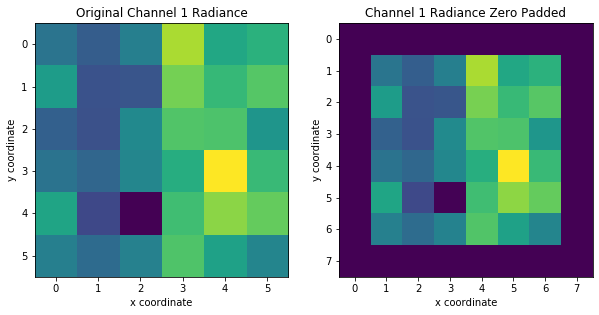

In [38]:
# padding the channel 1 image

zeropad_ch1 = np.pad(ch1,1,padding)
    
fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.imshow(ch1, cmap='viridis',interpolation='nearest')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Original Channel 1 Radiance')

plt.subplot(122)
plt.imshow(zeropad_ch1,cmap='viridis',interpolation='nearest')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Channel 1 Radiance Zero Padded')

plt.show()

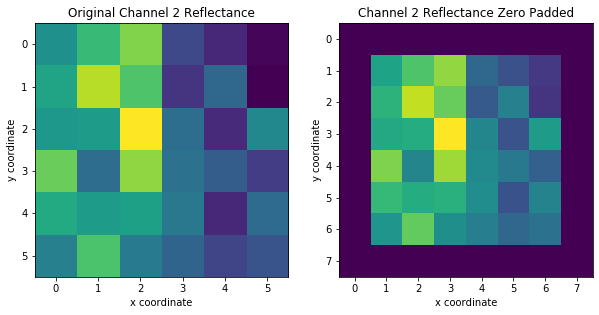

In [39]:
# Zero padded image for channel 2
zeropad_ch2 = np.pad(ch2,1,padding)

fig = plt.figure(figsize=(10,6))

plt.subplot(121)
plt.imshow(ch2, cmap='viridis',interpolation='nearest')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Original Channel 2 Reflectance')

plt.subplot(122)
plt.imshow(zeropad_ch2,cmap='viridis',interpolation='nearest')
plt.xlabel('x coordinate')
plt.ylabel('y coordinate')
plt.title('Channel 2 Reflectance Zero Padded')

plt.show()

The shape of image is (288, 432, 3)


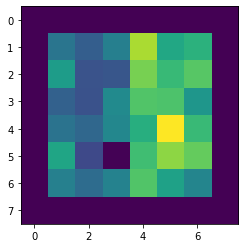

In [40]:
# channel 1 image 1
channel1 = plt.imshow(zeropad_ch1)
plt.savefig('channel1.png')
channel1 = 'channel1.png'
image1  = cv2.imread(channel1,1)
print('The shape of image is {}'.format(image1.shape))

The shape of image is (288, 432, 3)


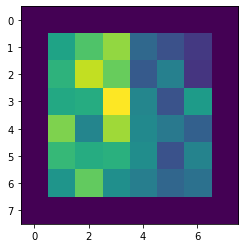

In [41]:
# channel 2 image 2
channel2 = plt.imshow(zeropad_ch2)
plt.savefig('channel2.png')
channel2 = 'channel2.png'
image2  = cv2.imread(channel2)
print('The shape of image is {}'.format(image2.shape))

In [42]:
# smoothing of Channel 1 image 

def smoothing_function(originalImage):
    
    zero_pad = np.pad(originalImage,1,padding)
    smoothedImage = [] #initialize second image

    for y in range(1, 7):
        for x in range(1, 7): 
            px1 = zero_pad[x-1][y-1] #0/0
            px2 = zero_pad[x-1][y] #0/1
            px3 = zero_pad[x-1][y+1] #0/2
            px4 = zero_pad[x][y-1] #1/0
            px5 = zero_pad[x][y] #1/1
            px6 = zero_pad[x][y+1] #1/2
            px7 = zero_pad[x+1][y-1] #2/0
            px8 = zero_pad[x+1][y] #2/1
            px9 = zero_pad[x+1][y+1] #2/2
            average = px1/9. + px2/9. + px3/9. + px4/9. + px5/9. + px6/9. + px7/9. + px8/9. + px9/9.
            smoothedImage.append(average)   #1/1

    smoothedImage = np.array(smoothedImage)
    smoothedImage = smoothedImage.reshape(6,6)
    return smoothedImage

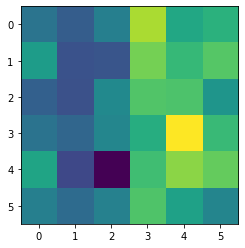

In [43]:
smoothedImage1 = smoothing_function(ch1)
plt.imshow(ch1)

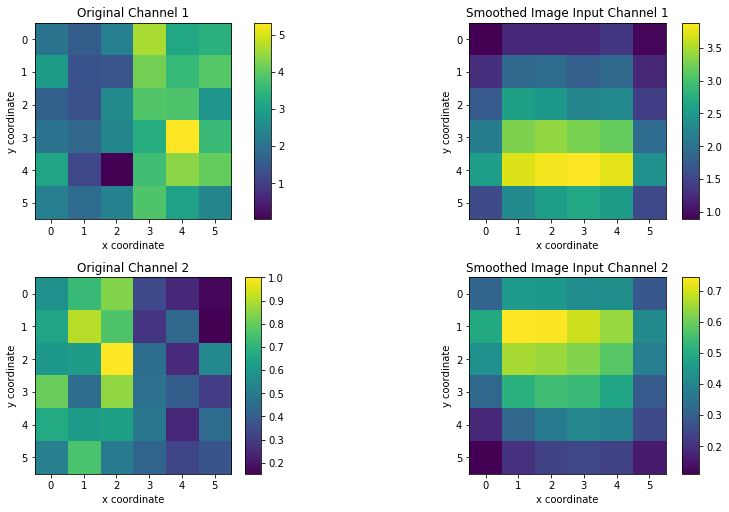

In [118]:
# Original Channel Vs Smoothed Image 

smoothedImage1 = smoothing_function(ch1)
smoothedImage2 = smoothing_function(ch2)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7),constrained_layout=True)
channels = [ch1,smoothedImage1,ch2,smoothedImage2]
titles  = ['Original Channel 1','Smoothed Image Input Channel 1','Original Channel 2','Smoothed Image Input Channel 2']

for ax,ch,title in zip(axs.flat,channels,titles):
    clrbar = ax.imshow(ch, cmap = 'viridis', interpolation='nearest')
    fig.colorbar(clrbar, ax=ax)
    ax.set_xlabel('x coordinate')
    ax.set_ylabel('y coordinate')
    ax.set_title(str(title))

### 7. By using the smoothed channel images, re-perform a Lloyd’s k-means unsupervised classification and then compute the confusion matrix (CM) and Cohen’s index (k).

In [53]:
smooth_df = pd.DataFrame({'smooth_ch1_image1': smoothedImage1.flatten(),'smooth_ch2_image2':smoothedImage2.flatten()})
smooth_df.head()

,smooth_ch1_image1,smooth_ch2_image2
0,0.885186,0.317779
1,1.217820,0.453661
2,1.234863,0.448979
3,1.232959,0.419341
4,1.366716,0.425715


In [54]:
# KMeans for Smoothed Images
km_smooth = KMeans(n_clusters=2)
km_smooth

km_smooth.fit_predict(smooth_df[['smooth_ch1_image1','smooth_ch2_image2']])
kpred = km_smooth.labels_ + 1 
smooth_df['cluster'] = kpred.copy()
smooth_df.head(10)

,smooth_ch1_image1,smooth_ch2_image2,cluster
0,0.885186,0.317779,1
1,1.217820,0.453661,1
2,1.234863,0.448979,1
3,1.232959,0.419341,1
4,1.366716,0.425715,1
5,0.943307,0.285408,1
6,1.300592,0.496267,1
7,1.915319,0.743260,1
8,1.949930,0.740783,1
9,1.792028,0.696289,1


In [55]:
#Confusion Matrix
ConfusionM2 =  confusion_matrix(df['label'],kpred)
ConfusionM2

array([[10,  8],
       [12,  6]], dtype=int64)

In [56]:
# Calculation of cohen kappa coefficient using sklearn library

from sklearn.metrics import confusion_matrix,cohen_kappa_score

cohen_kappa_score = cohen_kappa_score(df['label'],kpred)
print('The calculated value of Cohens kappa coefficient (κ) is {}'.format(cohen_kappa_score))

The calculated value of Cohens kappa coefficient (κ) is -0.11111111111111116


### 8. By using the collocated channel and parameter data, develop a statistical retrieval algorithm (e.g., linear regression) to estimate parameter value from spectral radiance (channel 1) and provide error bias (mean) and standard deviation in kelvins. 

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model =  LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
# loading the original dataset
df.head()

,radiance,reflectance,label,surface_temp
0,2.068526,0.579204,1,277.39425
1,1.588779,0.725697,1,266.11364
2,2.308740,0.838262,1,277.84215
3,4.651697,0.338762,2,297.25935
4,3.197330,0.246227,2,282.75330


In [79]:
# Training feature and target variables
X = df[['radiance','reflectance']]
y = df['surface_temp']

# splitting into Training and Test datasets
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.3,shuffle=True)

# Training the model
model.fit(Xtrain,ytrain)
ypred = model.predict(Xtest)
ypred

array([275.98984946, 274.7556571 , 274.25026475, 295.14013969,
       285.6689503 , 276.62226108, 288.4020606 , 278.78337108,
       289.66570838, 271.5854436 , 283.66673601])

In [80]:
# Model accuracy
acc = model.score(Xtest,ytest)
print('Accuracy score is {}'.format(acc))

Accuracy score is 0.8661700727584845


In [81]:
#Model Coefficients
model.coef_

array([ 5.2855341, -7.4170369])

In [82]:
# Model Intercept
model.intercept_

269.9849729670075

In [84]:
from sklearn.metrics import mean_squared_error

# Root mean squared Error

print('Root Mean Square Error is {}'.format(np.sqrt(mean_squared_error(ytest,ypred))))

Root Mean Square Error is 3.079780449344986


In [85]:
# Mean Squared Error
mse = mean_squared_error(ytest,ypred)
print('Mean Squared Error is {}'.format(mse))

Mean Squared Error is 9.485047616167604


In [115]:
# Manual implementation of the above function to calculate Variance and Standard deviation

def MSE(ytrue,ypred):
    var = (ytrue - ypred)
    n = len(var)
    tvar = var * var
    std  = np.sqrt(tvar)
    std = std.sum()/n    # taking standard deviation for n observations in the test data set
    
    MSE = tvar.sum()
    MSE = MSE/n
    
    return std,MSE

In [116]:
# Variance, Standard Deviation and MSE 

std,MSE = MSE(ytest,ypred)

print('Standard Deviation of the model is {} Kelvins'.format(std))
print('Error Bias or Mean of the model is {}'.format(MSE))

Standard Deviation of the model is 2.5117274636153195 Kelvins
Error Bias or Mean of the model is 9.485047616167604
